
# 03 - Modular Enhancements

This notebook mirrors the Part 3 experiments but keeps the code lightweight by
relying on helper modules in `src/`.


## Imports & shared setup

In [41]:
from pathlib import Path

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import Markdown, display
from dataclasses import replace, dataclass

from src.config import load_data_config
from src.dataset_pipeline import prepare_tokenised_splits
from src.embeddings import load_torchtext_glove
from src.reports import build_vocabulary_report
from src.models.birnn import BiLSTMClassifier, BiGRUClassifier
from src.models.cnn import CNNTextClassifier
from src.training import (
    RNNExperimentConfig,
    train_rnn_model,
    build_dataloaders_and_vocab,
    run_model_experiment,
    summarise_run,
)
from src.evaluation import evaluate_model, topic_accuracy_table, classification_report_table
from src.plotting import plot_training_curves, latex_set_size, plot_barplot, plot_support_and_f1_by_topic

SEED = 7
sns.set_theme(style="whitegrid")

## Data & embeddings

In [2]:
data_config = load_data_config(Path('configs/data.yaml'))
splits = prepare_tokenised_splits(data_config)
len(splits.train), len(splits.validation), len(splits.test)

(4361, 1091, 500)

In [3]:
vocab_report = build_vocabulary_report(
    tokenised_dataset=splits.train,
    min_freq=data_config.vocabulary_min_freq,
    specials=data_config.vocabulary_specials,
)
embedding_result = load_torchtext_glove(
    vocabulary=vocab_report.vocabulary,
    name='6B',
    dim=100,
    trainable=True,
    random_seed=SEED,
)
embedding_tensor = torch.tensor(embedding_result.matrix, dtype=torch.float32)

## Shared experiment configuration

In [4]:
base_config = RNNExperimentConfig(
    epochs=15,
    batch_size=64,
    hidden_dim=128,
    num_layers=1,
    dropout=0.3,
    learning_rate=1e-3,
    weight_decay=1e-4,
    grad_clip=1.0,
    pooling='last_hidden',
    optimizer='adam',
    early_stopping_patience=3,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaders, label_to_index = build_dataloaders_and_vocab(base_config, splits, vocab_report.vocabulary)
records = {'rows': [], 'histories': {}, 'evaluations': {}, 'label_maps': {}}

## Baseline RNN

Baseline test accuracy: 0.872

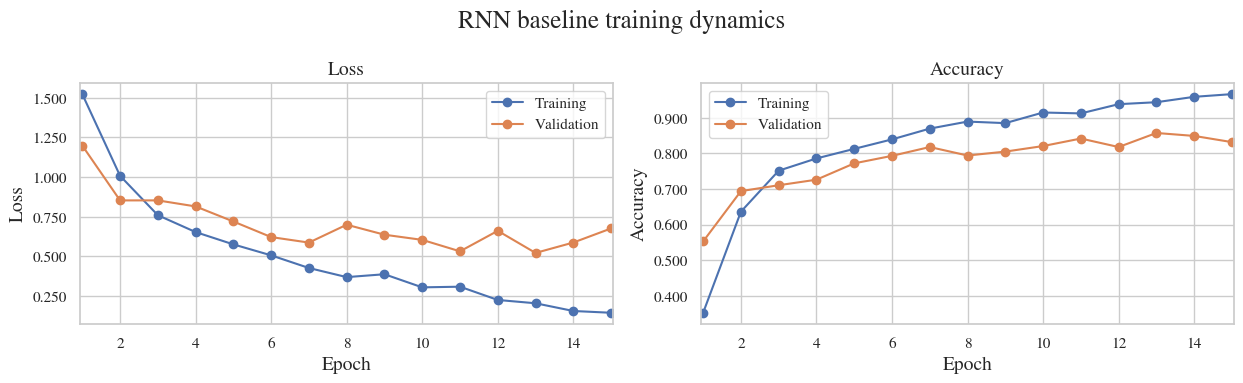

In [6]:
b_hist, b_model, b_label_map, b_loaders = train_rnn_model(
    base_config,
    splits=splits,
    vocabulary=vocab_report.vocabulary,
    embedding_result=embedding_result,
    device=device,
)
b_eval = evaluate_model(b_model, b_loaders.test, device=device)
records['histories']['rnn_baseline'] = b_hist
records['evaluations']['rnn_baseline'] = b_eval
records['label_maps']['rnn_baseline'] = b_label_map
records['rows'].append(summarise_run('rnn_baseline', b_hist, b_eval.accuracy))
plot_training_curves(
    b_hist,
    title='RNN baseline training dynamics',
    output_path=Path('plots/part3_rnn_baseline_curves.png'),
    figure_fraction=1
)
display(Markdown(f"Baseline test accuracy: {b_eval.accuracy:.3f}"))

## biLSTM

biLSTM test accuracy: 0.886

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

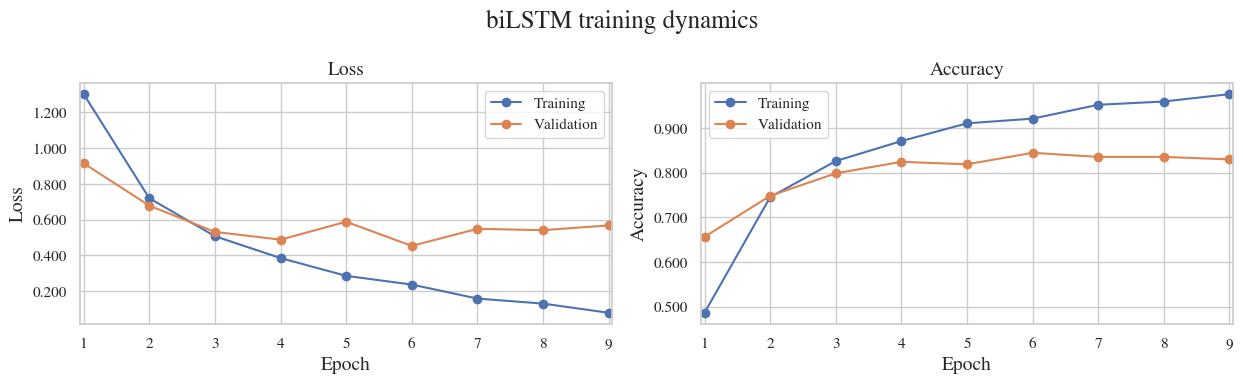

In [7]:
hist_bilstm, model_bilstm, eval_bilstm = run_model_experiment(
    'bilstm',
    model_builder=lambda: BiLSTMClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bilstm'] = hist_bilstm
records['evaluations']['bilstm'] = eval_bilstm
records['label_maps']['bilstm'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bilstm', hist_bilstm, eval_bilstm.accuracy))
display(Markdown(f"biLSTM test accuracy: {eval_bilstm.accuracy:.3f}"))
plot_training_curves(
    hist_bilstm,
    title='biLSTM training dynamics',
    output_path=Path('plots/part3_bilstm_curves.png'),
    figure_fraction=1
)

/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:319: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


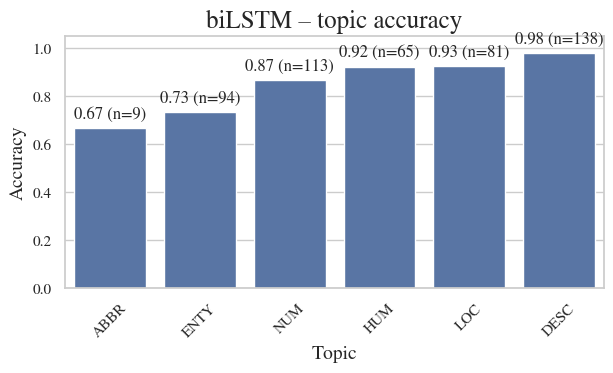

In [ ]:
bilstm_topic_df = topic_accuracy_table(eval_bilstm, records['label_maps']['bilstm'])
sorted_bilstm_topics = bilstm_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_bilstm_topics['label'],
    y=sorted_bilstm_topics['accuracy'],
    title='biLSTM – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bilstm_topics['accuracy'],
        sorted_bilstm_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_bilstm_topic_accuracy.png', dpi=300)
plt.show()


## biGRU

biGRU test accuracy: 0.894

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

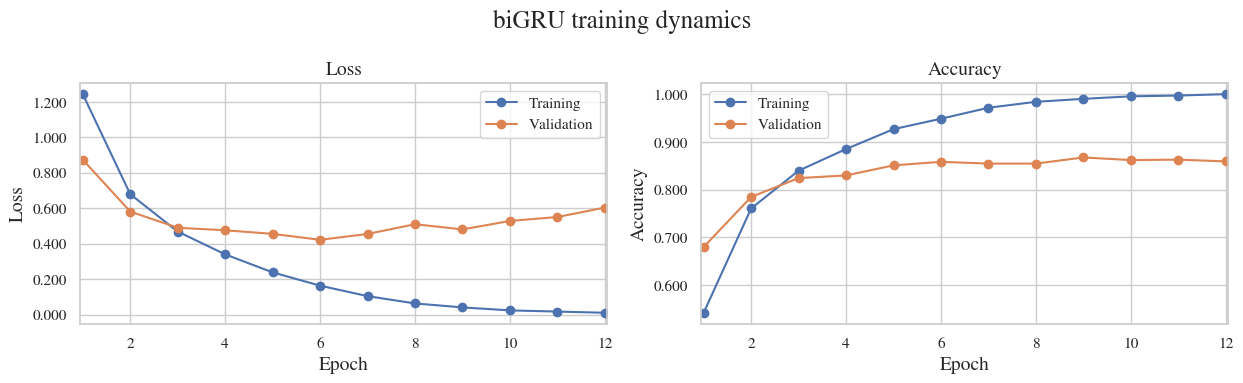

In [21]:
hist_bigru, model_bigru, eval_bigru = run_model_experiment(
    'bigru',
    model_builder=lambda: BiGRUClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        hidden_dim=base_config.hidden_dim,
        num_layers=base_config.num_layers,
        dropout=base_config.dropout,
    ),
    config=base_config,
    loaders=loaders,
    device=device,
)
records['histories']['bigru'] = hist_bigru
records['evaluations']['bigru'] = eval_bigru
records['label_maps']['bigru'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('bigru', hist_bigru, eval_bigru.accuracy))
display(Markdown(f"biGRU test accuracy: {eval_bigru.accuracy:.3f}"))
plot_training_curves(
    hist_bigru,
    title='biGRU training dynamics',
    output_path=Path('plots/part3_bigru_curves.png'),
    figure_fraction=1

)

/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:319: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


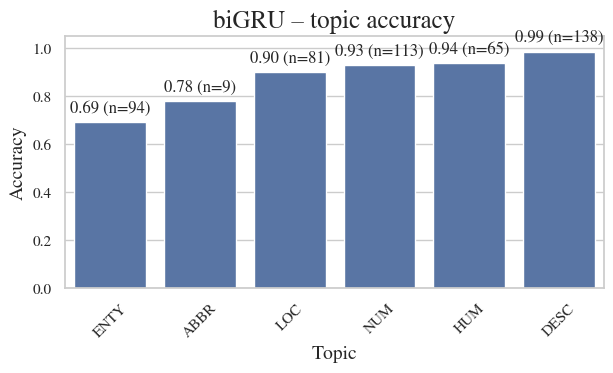

In [45]:
bigru_topic_df = topic_accuracy_table(eval_bigru, records['label_maps']['bigru'])
sorted_bigru_topics = bigru_topic_df.sort_values('accuracy')
fig, ax = plot_barplot(
    x=sorted_bigru_topics['label'],
    y=sorted_bigru_topics['accuracy'],
    title='biGRU – topic accuracy',
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_bigru_topics['accuracy'],
        sorted_bigru_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig('plots/part3_bigru_topic_accuracy.png', dpi=300)
plt.show()


## CNN

CNN test accuracy: 0.888

(<Figure size 1259.84x389.313 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epoch', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Accuracy'>],
       dtype=object))

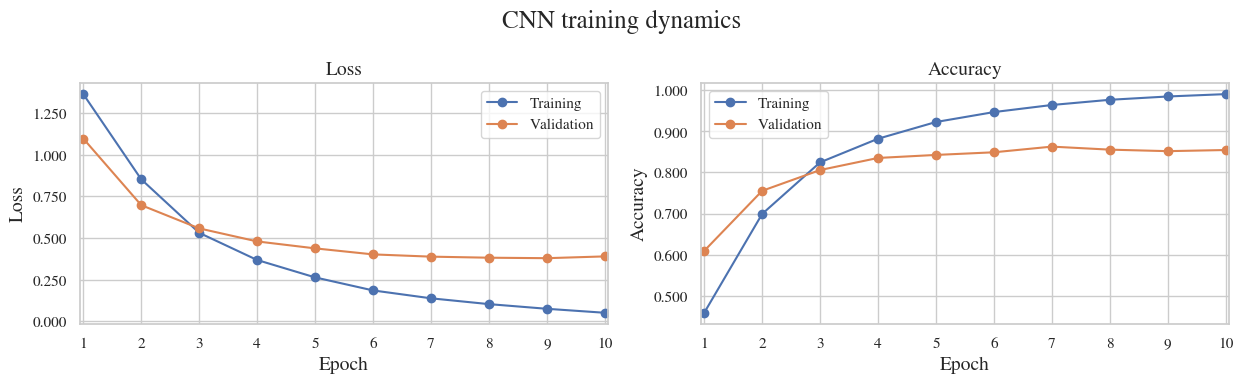

In [24]:
cnn_config = replace(base_config, dropout=0.5, weight_decay=0.0, grad_clip=0.0)
hist_cnn, model_cnn, eval_cnn = run_model_experiment(
    'cnn',
    model_builder=lambda: CNNTextClassifier(
        embedding_matrix=embedding_tensor.clone(),
        num_classes=len(label_to_index),
        dropout=cnn_config.dropout,
    ),
    config=cnn_config,
    loaders=loaders,
    device=device,
)
records['histories']['cnn'] = hist_cnn
records['evaluations']['cnn'] = eval_cnn
records['label_maps']['cnn'] = {idx: label for label, idx in label_to_index.items()}
records['rows'].append(summarise_run('cnn', hist_cnn, eval_cnn.accuracy))
display(Markdown(f"CNN test accuracy: {eval_cnn.accuracy:.3f}"))
plot_training_curves(
    hist_cnn,
    title='CNN training dynamics',
    output_path=Path('plots/part3_cnn_curves.png'),
    figure_fraction=1
    
)

## Summary & comparison

,best_epoch,val_accuracy,test_accuracy
name,,,
bigru,10,0.868928,0.902
bigru,9,0.867094,0.894
cnn,7,0.862511,0.888
bilstm,6,0.844180,0.886
rnn_baseline,13,0.857012,0.872
rnn_baseline,15,0.854262,0.860


/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:319: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


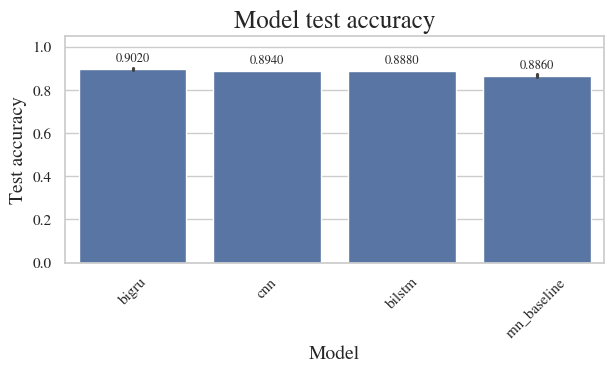

Best model: **bigru** (test accuracy 0.902)

,label,accuracy,support
2,ENTY,0.691489,94
0,ABBR,0.777778,9
4,LOC,0.901235,81
5,NUM,0.929204,113
3,HUM,0.938462,65
1,DESC,0.985507,138


/Users/petterollinen/GitHub/NLP_Project_group45/src/plotting.py:319: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


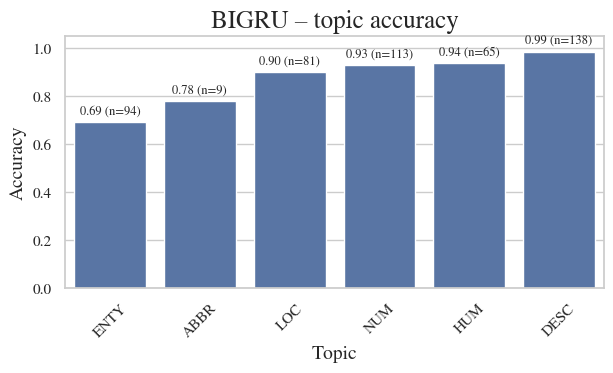

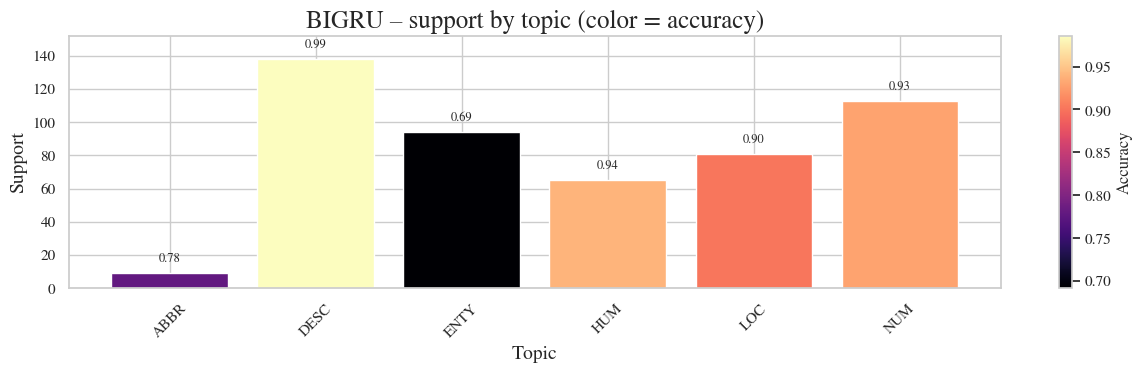

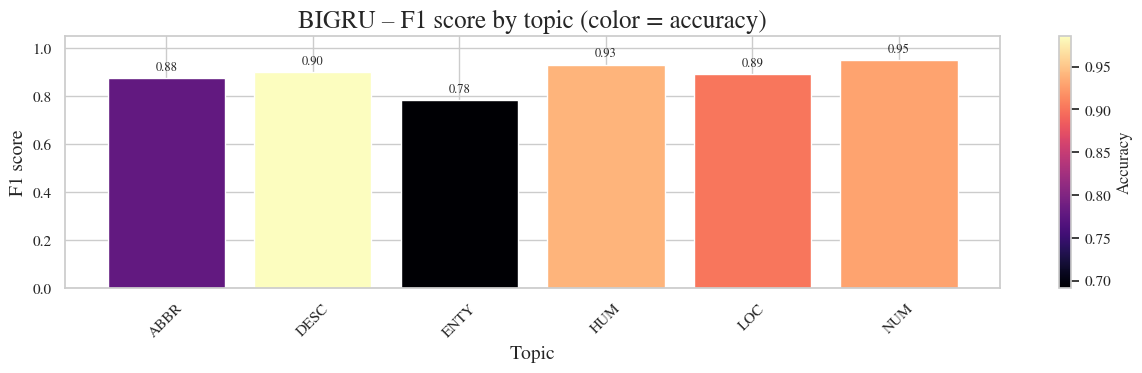

,precision,recall,f1-score,support
accuracy,0.894000,0.894000,0.894000,0.894
macro avg,0.918005,0.870612,0.888427,500.000
weighted avg,0.898956,0.894000,0.891601,500.000


In [47]:
comparison_df = pd.DataFrame(records['rows']).set_index('name').sort_values('test_accuracy', ascending=False)
display(comparison_df)

fig, ax = plot_barplot(
    x=comparison_df.index,
    y=comparison_df['test_accuracy'],
    title='Model test accuracy',
)
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Test accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
label_values = [f"{score:.4f}" for score in comparison_df['test_accuracy']]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, label_values):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
plt.show()

best_row = comparison_df.iloc[0]
best_name = best_row.name
best_eval = records['evaluations'][best_name]
best_history = records['histories'][best_name]
best_label_map = records['label_maps'][best_name]
best_accuracy = float(best_row['test_accuracy'])
display(Markdown(f"Best model: **{best_name}** (test accuracy {best_accuracy:.3f})"))

best_topic_df = topic_accuracy_table(best_eval, best_label_map)
sorted_best_topics = best_topic_df.sort_values('accuracy')
display(sorted_best_topics)

fig, ax = plot_barplot(
    x=sorted_best_topics['label'],
    y=sorted_best_topics['accuracy'],
    title=f"{best_name.upper()} – topic accuracy",
)
ax.set_xlabel('Topic', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0, 1.05)
topic_labels = [
    f"{acc:.2f} (n={supp})" for acc, supp in zip(
        sorted_best_topics['accuracy'],
        sorted_best_topics['support'],
    )
]
bar_container = next((container for container in ax.containers if hasattr(container, 'datavalues')), None)
if bar_container is not None:
    for rect, label in zip(bar_container.patches, topic_labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.02,
            label,
            ha='center',
            va='bottom',
            fontsize=9,
        )
fig.savefig(f"plots/part3_{best_name}_topic_accuracy.png", dpi=300)
plt.show()

best_report_df = classification_report_table(best_eval, best_label_map)
label_rows = best_report_df.loc[~best_report_df.index.isin(['accuracy', 'macro avg', 'weighted avg', 'micro avg'])].copy()
if 'accuracy' not in label_rows.columns:
    label_rows['accuracy'] = label_rows.get('recall', 0.0)

plot_support_and_f1_by_topic(
    label_rows,
    support_title=f"{best_name.upper()} – support by topic (color = accuracy)",
    f1_title=f"{best_name.upper()} – F1 score by topic (color = accuracy)",
    xlabel='Topic',
    support_ylabel='Support',
    f1_ylabel='F1 score',
    support_output_path=f"plots/part3_{best_name}_classification_support.png",
    f1_output_path=f"plots/part3_{best_name}_classification_f1.png",
)

averages_df = best_report_df.loc[
    ['accuracy', 'macro avg', 'weighted avg'],
    [col for col in best_report_df.columns if col in ['precision', 'recall', 'f1-score', 'support']],
]
display(averages_df)
